<a href="https://colab.research.google.com/github/DrMiracle/Colab-Projects/blob/main/NLP/Style%20transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETL

In [ ]:
!pip install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import spacy
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from transformers import AutoTokenizer
from tokenizers.processors import TemplateProcessing
from transformers import T5Tokenizer, T5ForConditionalGeneration

from google.colab import files
import shutil

import random

from tqdm import tqdm

In [ ]:
!git clone https://huggingface.co/datasets/RUCAIBox/Style-Transfer

Cloning into 'Style-Transfer'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11 (from 1)
Unpacking objects: 100% (11/11), 1.62 KiB | 87.00 KiB/s, done.


In [ ]:
!tar -xvzf Style-Transfer/gyafc_em.tgz
!tar -xvzf Style-Transfer/gyafc_fr.tgz

gyafc_em/
gyafc_em/valid.src
gyafc_em/test.tgt
gyafc_em/train.tgt
gyafc_em/train.src
gyafc_em/.DS_Store
gyafc_em/valid.tgt
gyafc_em/test.src
gyafc_fr/
gyafc_fr/valid.src
gyafc_fr/test.tgt
gyafc_fr/train.tgt
gyafc_fr/train.src
gyafc_fr/.DS_Store
gyafc_fr/valid.tgt
gyafc_fr/test.src


In [ ]:
with open("gyafc_fr/train.src", "r") as f:
  print("Input:")
  print(f.readline())

with open("gyafc_fr/train.tgt", "r") as f:
  print("Target:")
  print(f.readline())

Input:
Sure, it's ok, but I always have let the guy ask me.

Target:
I prefer to let the guy ask me.



In [ ]:
data_paths = {
    "gyafc_em": "gyafc_em",
    "gyafc_fr": "gyafc_fr"
}

def load_split(domain_path, split):
    """Load a dataset split (train/valid/test) from a specific domain."""
    src_path = os.path.join(domain_path, f"{split}.src")
    tgt_path = os.path.join(domain_path, f"{split}.tgt")

    with open(src_path, "r", encoding="utf-8") as src_file:
        src_sentences = src_file.readlines()
    with open(tgt_path, "r", encoding="utf-8") as tgt_file:
        tgt_sentences = tgt_file.readlines()

    return pd.DataFrame({"informal": src_sentences, "formal": tgt_sentences})

# Load all splits for both domains
data = {}
for domain, path in data_paths.items():
    data[domain] = {
        "train": load_split(path, "train"),
        "valid": load_split(path, "valid"),
        "test": load_split(path, "test")
    }


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("t5-small", bos_token = "<s>")
tokenizer._tokenizer.post_processor = TemplateProcessing(
    single="<s> $A </s>",
    pair="<s> $A </s> <s> $B </s>",
    special_tokens=[("</s>", tokenizer.eos_token_id), ("<s>", tokenizer.bos_token_id)]
)
BOS_INDEX = tokenizer.bos_token_id
PAD_INDEX = tokenizer.pad_token_id
EOS_INDEX = tokenizer.eos_token_id
VOCAB_SIZE = tokenizer.vocab_size+1

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
HIDDEN_SIZE = 516
LEARNING_RATE = 0.001
NUM_EPOCHS = 5
BATCH_SIZE = 64
MAX_LENGTH = 110

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# EDA

In [ ]:
for domain, splits in data.items():
    for split, df in splits.items():
        missing_informal = df["informal"].isnull().sum()
        missing_formal = df["formal"].isnull().sum()
        print(f"{domain} ({split}): Missing informal sentences = {missing_informal}, Missing formal sentences = {missing_formal}")


gyafc_em (train): Missing informal sentences = 0, Missing formal sentences = 0
gyafc_em (valid): Missing informal sentences = 0, Missing formal sentences = 0
gyafc_em (test): Missing informal sentences = 0, Missing formal sentences = 0
gyafc_fr (train): Missing informal sentences = 0, Missing formal sentences = 0
gyafc_fr (valid): Missing informal sentences = 0, Missing formal sentences = 0
gyafc_fr (test): Missing informal sentences = 0, Missing formal sentences = 0


In [ ]:
for domain, splits in data.items():
    for split, df in splits.items():
        print(f"{domain} ({split}): Total sentence pairs = {len(df)}")

gyafc_em (train): Total sentence pairs = 52595
gyafc_em (valid): Total sentence pairs = 2877
gyafc_em (test): Total sentence pairs = 1416
gyafc_fr (train): Total sentence pairs = 51967
gyafc_fr (valid): Total sentence pairs = 2788
gyafc_fr (test): Total sentence pairs = 1332


In [ ]:
for domain, splits in data.items():
    for split, df in splits.items():
        df["informal_len"] = df["informal"].str.split().apply(len)
        df["formal_len"] = df["formal"].str.split().apply(len)

for domain, splits in data.items():
    print(f"Domain: {domain}")
    for split, df in splits.items():
        print(f"  {split.capitalize()} split:")
        print(f"    Informal sentence length: max={df['informal_len'].max()}, min={df['informal_len'].min()}, mean={df['informal_len'].mean():.2f}, std={df['informal_len'].std():.2f}")
        print(f"    Formal sentence length: max={df['formal_len'].max()}, min={df['formal_len'].min()},mean={df['formal_len'].mean():.2f}, std={df['formal_len'].std():.2f}")

print("\n")
for domain in data:
    avg_informal = data[domain]["train"]["informal_len"].mean()
    avg_formal = data[domain]["train"]["formal_len"].mean()
    print(f"{domain}: Avg Informal Length = {avg_informal:.2f}, Avg Formal Length = {avg_formal:.2f}")


Domain: gyafc_em
  Train split:
    Informal sentence length: max=19, min=6, mean=9.93, std=3.53
    Formal sentence length: max=41, min=3,mean=10.63, std=4.24
  Valid split:
    Informal sentence length: max=19, min=6, mean=9.94, std=3.49
    Formal sentence length: max=107, min=15,mean=42.01, std=14.54
  Test split:
    Informal sentence length: max=19, min=6, mean=10.14, std=3.60
    Formal sentence length: max=109, min=14,mean=42.65, std=15.09
Domain: gyafc_fr
  Train split:
    Informal sentence length: max=19, min=6, mean=10.67, std=3.75
    Formal sentence length: max=40, min=3,mean=11.32, std=4.33
  Valid split:
    Informal sentence length: max=19, min=6, mean=10.35, std=3.61
    Formal sentence length: max=91, min=16,mean=42.24, std=14.10
  Test split:
    Informal sentence length: max=19, min=6, mean=10.76, std=3.74
    Formal sentence length: max=94, min=16,mean=44.62, std=14.79


gyafc_em: Avg Informal Length = 9.93, Avg Formal Length = 10.63
gyafc_fr: Avg Informal Length 

In [ ]:
informal_vocab = set(word for sentence in data["gyafc_em"]["train"]["informal"] for word in sentence.split())
formal_vocab = set(word for sentence in data["gyafc_em"]["train"]["formal"] for word in sentence.split())

overlap = len(informal_vocab & formal_vocab)
total_vocab = len(informal_vocab | formal_vocab)
print(f"Vocabulary Overlap: {overlap / total_vocab * 100:.2f}%")

Vocabulary Overlap: 25.34%


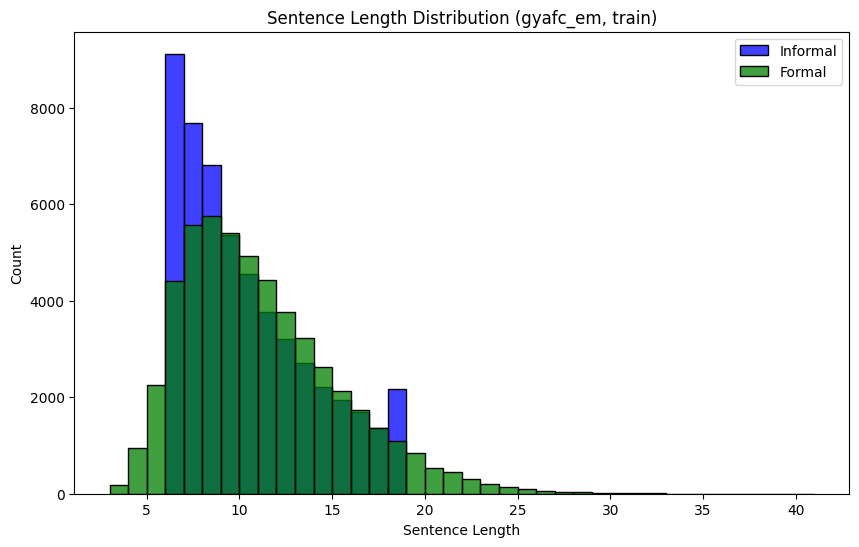

In [ ]:
def plot_sentence_length_distribution(domain, split):
    df = data[domain][split]
    plt.figure(figsize=(10, 6))
    sns.histplot(df["informal_len"], label="Informal", color="blue", binwidth=1)
    sns.histplot(df["formal_len"], label="Formal", color="green", binwidth=1)
    plt.title(f"Sentence Length Distribution ({domain}, {split})")
    plt.xlabel("Sentence Length")
    plt.legend()
    plt.show()

plot_sentence_length_distribution("gyafc_em", "train")


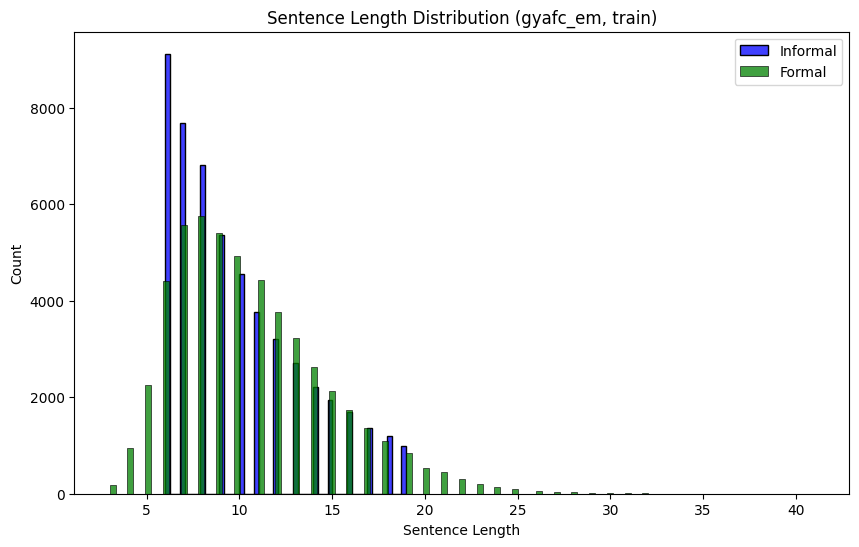

In [ ]:
plot_sentence_length_distribution("gyafc_em", "train")

In [ ]:
def get_word_frequencies(texts, top_n=20):
    all_words = [word.lower() for sentence in texts for word in sentence.split()]
    return Counter(all_words).most_common(top_n)

In [ ]:
domain = "gyafc_em"
split = "train"
informal_words = get_word_frequencies(data[domain][split]["informal"])
formal_words = get_word_frequencies(data[domain][split]["formal"])
print("Top 20 Informal Words:", informal_words)
print("Top 20 Formal Words:", formal_words)

Top 20 Informal Words: [('i', 19455), ('the', 15832), ('a', 10781), ('and', 10417), ('to', 9672), ('it', 8517), ('you', 7774), ('is', 7768), ('of', 5868), ('that', 5543), ('but', 5264), ('like', 4483), ('in', 4466), ('on', 3957), ('have', 3498), ('they', 3391), ('my', 3339), ('not', 3152), ('for', 3150), ('he', 3082)]
Top 20 Formal Words: [('i', 25019), ('the', 21662), ('is', 15202), ('to', 12895), ('you', 11791), ('a', 11691), ('and', 10437), ('it', 10031), ('that', 8538), ('not', 8346), ('of', 7521), ('in', 5456), ('are', 5182), ('do', 4757), ('have', 4687), ('was', 4031), ('on', 3981), ('my', 3972), ('but', 3934), ('he', 3667)]


In [ ]:
def plot_wordcloud(texts, title):
    all_text = " ".join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

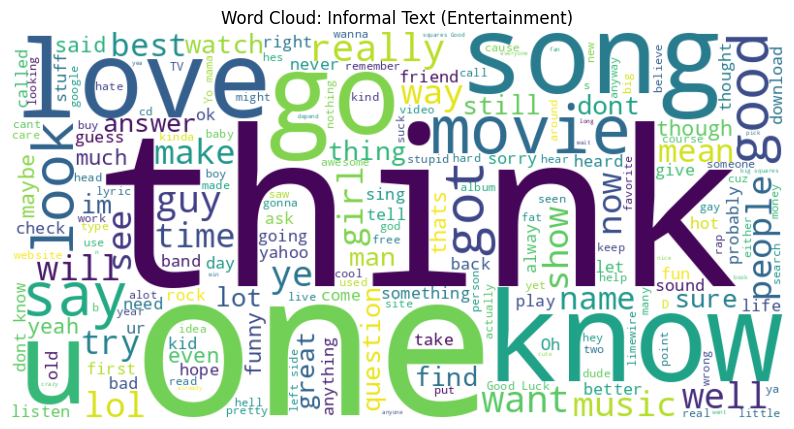

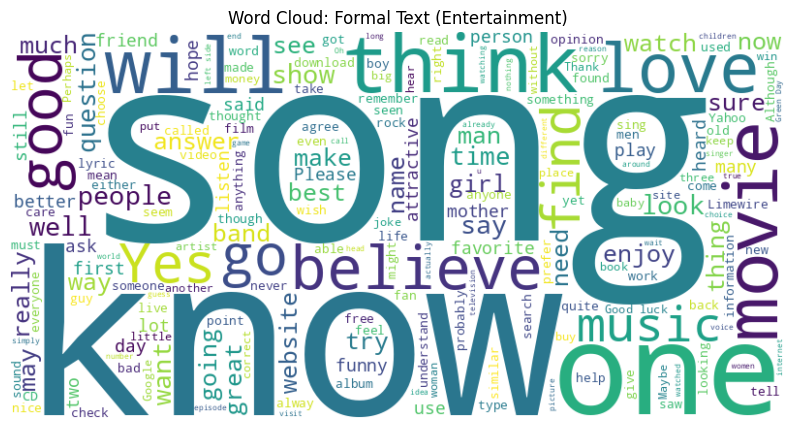

In [ ]:
plot_wordcloud(data["gyafc_em"]["train"]["informal"], "Word Cloud: Informal Text (Entertainment)")
plot_wordcloud(data["gyafc_em"]["train"]["formal"], "Word Cloud: Formal Text (Entertainment)")

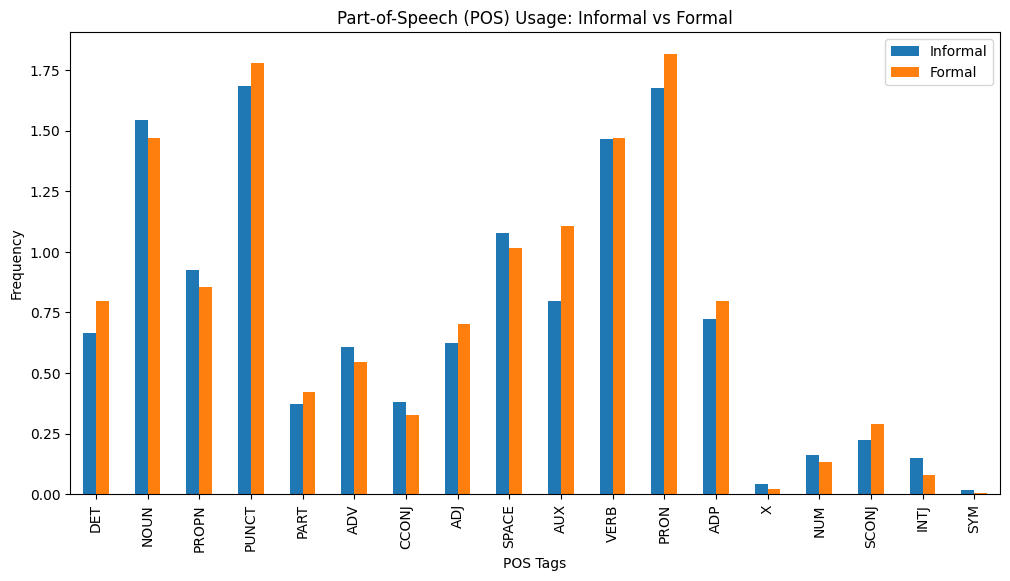

In [ ]:

nlp = spacy.load("en_core_web_sm")

def pos_tag_analysis(texts):
    pos_counts = []
    for doc in nlp.pipe(texts, disable=["ner", "textcat"]):
        counts = doc.count_by(spacy.attrs.POS)
        pos_counts.append({nlp.vocab.strings[pos]: count for pos, count in counts.items()})
    return pd.DataFrame(pos_counts).fillna(0)

informal_pos = pos_tag_analysis(data["gyafc_em"]["train"]["informal"])
formal_pos = pos_tag_analysis(data["gyafc_em"]["train"]["formal"])

pos_comparison = informal_pos.mean().to_frame("Informal").join(formal_pos.mean().to_frame("Formal"))
pos_comparison.plot(kind="bar", figsize=(12, 6))
plt.title("Part-of-Speech (POS) Usage: Informal vs Formal")
plt.xlabel("POS Tags")
plt.ylabel("Frequency")
plt.show()


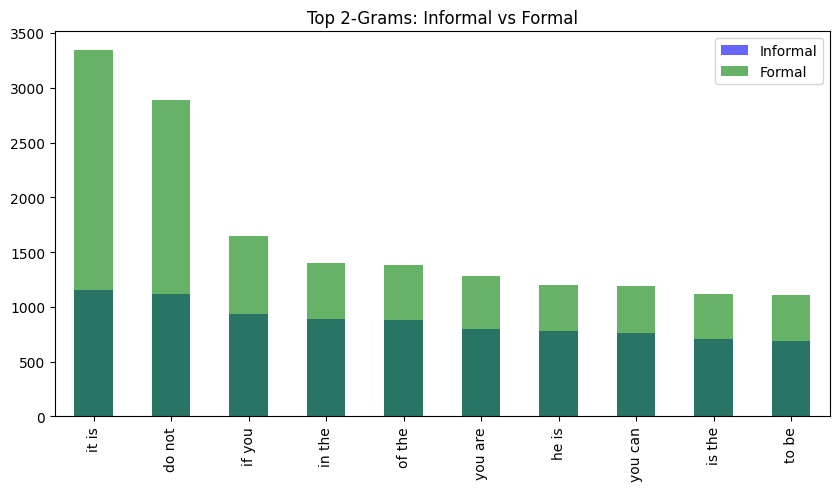

In [ ]:
def extract_ngrams(texts, n=2, top_n=20):
    vectorizer = CountVectorizer(ngram_range=(n, n), max_features=top_n)
    X = vectorizer.fit_transform(texts)
    return pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

informal_ngrams = extract_ngrams(data["gyafc_em"]["train"]["informal"], n=2, top_n=10)
formal_ngrams = extract_ngrams(data["gyafc_em"]["train"]["formal"], n=2, top_n=10)

informal_ngrams.plot(kind="bar", color="blue", alpha=0.6, label="Informal", figsize=(10, 5))
formal_ngrams.plot(kind="bar", color="green", alpha=0.6, label="Formal")
plt.title("Top 2-Grams: Informal vs Formal")
plt.legend()
plt.show()


In [ ]:
def calculate_bleu_scores(df):
    bleu_scores = []
    for informal, formal in zip(df["informal"], df["formal"]):
        reference = [formal.split()]
        candidate = informal.split()
        score = sentence_bleu(reference, candidate, weights=(0.5, 0.5))
        bleu_scores.append(score)
    return np.mean(bleu_scores)

for domain, splits in data.items():
    print(f"--- BLEU Scores for domain: {domain} ---")
    for split, df in splits.items():
        bleu_score = calculate_bleu_scores(df)
        print(f"Split: {split} -> Avg BLEU Score: {bleu_score:.2f}")


--- BLEU Scores for domain: gyafc_em ---


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Split: train -> Avg BLEU Score: 0.26
Split: valid -> Avg BLEU Score: 0.02
Split: test -> Avg BLEU Score: 0.02
--- BLEU Scores for domain: gyafc_fr ---
Split: train -> Avg BLEU Score: 0.29
Split: valid -> Avg BLEU Score: 0.03
Split: test -> Avg BLEU Score: 0.03


# Training

In [ ]:
def read_dataframe(source, target, train = True):
    df = []
    with open(source, "r") as src, open(target, "r") as tgt:
        for s, t in zip(src, tgt):
            df.append({
                "source": s,
                "target": t if train else eval(t)
            })
    return pd.DataFrame(df)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        input_ids = self.tokenizer(self.dataframe['source'][idx], max_length=MAX_LENGTH, padding="max_length", truncation=True, return_tensors="pt")["input_ids"].squeeze()
        target_ids = self.tokenizer(self.dataframe['target'][idx], max_length=MAX_LENGTH, padding="max_length", truncation=True, return_tensors="pt")["input_ids"].squeeze()
        return input_ids, target_ids

class Encoder(nn.Module):

    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = Attention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(BOS_INDEX)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):

    total_loss = 0
    for input, target in tqdm(dataloader):
        input, target = input.to(device), target.to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def evaluate_bleu(dataloader, encoder, decoder):
    total_bleu = 0
    with torch.no_grad():
        for input, target in tqdm(dataloader):
            input, target = input.to(device), target.to(device)

            encoder_outputs, encoder_hidden = encoder(input)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden)

            _, topi = decoder_outputs.topk(1)
            decoded_ids = topi.reshape(input.shape[0], -1)

            hypothesis = [tokenizer.decode(ids) for ids in decoded_ids]
            references = [[tokenizer.decode(t) for t in l_t] for l_t in target]

            total_bleu += corpus_bleu(references, hypothesis)

    return total_bleu / len(dataloader)

In [ ]:
train_df = read_dataframe("gyafc_em/train.src", "gyafc_em/train.tgt")
valid_df = read_dataframe("gyafc_em/valid.src", "gyafc_em/valid.tgt", train = False)
test_df = read_dataframe("gyafc_em/test.src", "gyafc_em/test.tgt", train = False)

train_dataset = TextDataset(train_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = TextDataset(valid_df, tokenizer)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

encoder = Encoder(VOCAB_SIZE, HIDDEN_SIZE).to(device)
decoder = Decoder(HIDDEN_SIZE, VOCAB_SIZE).to(device)

en_optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
de_optimizer = optim.Adam(decoder.parameters(), lr=LEARNING_RATE)
criterion = nn.NLLLoss(ignore_index=tokenizer.pad_token_id)

losses = []
bleus = []
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(train_loader, encoder, decoder, en_optimizer, de_optimizer, criterion)
    bleu = evaluate_bleu(valid_loader, encoder, decoder)

    if not bleus or bleu > max(bleus):
       torch.save(encoder.state_dict(), "./encoder.pt")
       torch.save(decoder.state_dict(), "./decoder.pt")

    losses.append(train_loss)
    bleus.append(bleu)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Bleu: {bleu:.4f}")

100%|██████████| 206/206 [04:10<00:00,  1.22s/it]


Epoch 1/20, Train Loss: 5.0356


100%|██████████| 206/206 [04:11<00:00,  1.22s/it]


Epoch 2/20, Train Loss: 3.9404


100%|██████████| 206/206 [04:12<00:00,  1.23s/it]


Epoch 3/20, Train Loss: 3.3495


100%|██████████| 206/206 [04:11<00:00,  1.22s/it]


Epoch 4/20, Train Loss: 2.8944


100%|██████████| 206/206 [04:13<00:00,  1.23s/it]


Epoch 5/20, Train Loss: 2.5225


100%|██████████| 206/206 [04:12<00:00,  1.22s/it]


Epoch 6/20, Train Loss: 2.2128


100%|██████████| 206/206 [04:12<00:00,  1.22s/it]


Epoch 7/20, Train Loss: 1.9575


100%|██████████| 206/206 [04:12<00:00,  1.23s/it]


Epoch 8/20, Train Loss: 1.7486


100%|██████████| 206/206 [04:12<00:00,  1.23s/it]


Epoch 9/20, Train Loss: 1.5760


100%|██████████| 206/206 [04:12<00:00,  1.22s/it]


Epoch 10/20, Train Loss: 1.4342


100%|██████████| 206/206 [04:12<00:00,  1.23s/it]


Epoch 11/20, Train Loss: 1.3140


100%|██████████| 206/206 [04:12<00:00,  1.22s/it]


Epoch 12/20, Train Loss: 1.2118


100%|██████████| 206/206 [04:12<00:00,  1.22s/it]


Epoch 13/20, Train Loss: 1.1258


100%|██████████| 206/206 [04:11<00:00,  1.22s/it]


Epoch 14/20, Train Loss: 1.0483


100%|██████████| 206/206 [04:12<00:00,  1.22s/it]


Epoch 15/20, Train Loss: 0.9812


100%|██████████| 206/206 [04:12<00:00,  1.22s/it]


Epoch 16/20, Train Loss: 0.9214


100%|██████████| 206/206 [04:11<00:00,  1.22s/it]


Epoch 17/20, Train Loss: 0.8667


100%|██████████| 206/206 [04:11<00:00,  1.22s/it]


Epoch 18/20, Train Loss: 0.8183


100%|██████████| 206/206 [04:12<00:00,  1.22s/it]


Epoch 19/20, Train Loss: 0.7760


100%|██████████| 206/206 [04:12<00:00,  1.22s/it]

Epoch 20/20, Train Loss: 0.7344


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(losses, marker='o', linestyle='-', color='b', label='Loss')
plt.title("Loss Curve", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10)
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(bleus, marker='o', linestyle='-', color='b', label='Bleu')
plt.title("Bleu Curve", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Bleu", fontsize=12)
plt.legend(fontsize=10)
plt.show()

In [ ]:
test_dataset = TextDataset(test_df, tokenizer)
test_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

bleu = evaluate_bleu(test_loader, encoder, decoder)
print(f"Test bleu: {bleu:.4f}")

In [ ]:
def evaluate(encoder, decoder, sentence):
    with torch.no_grad():
        input_tensor = tokenizer([sentence], max_length=MAX_LENGTH, padding="max_length", truncation=True, return_tensors="pt")["input_ids"].squeeze().to(device)
        input_tensor = input_tensor.unsqueeze(0)
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_INDEX:
                decoded_words.append('</s>')
                break
            decoded_words.append(tokenizer.decode(idx))
    return decoded_words, decoder_attn

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = test_df.sample()
        print('>', pair['source'].iloc[0], end='')
        print('=', pair['target'].iloc[0])
        output_words, _ = evaluate(encoder, decoder, pair['source'].iloc[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
evaluateRandomly(encoder, decoder, n=5)

> I don't know..never tried the stuff??
= ['I have never tried it.', 'I do not know. I never tried the stuff?', 'I do not know, as I have never tried it.', 'I do not know, I have never tried it.']
< <s> I do not know . I have tried tried the material . </s>

> Plus, she needs to get a damn job!
= ['And she needs to seek real employment!', 'She must find gainful employment.', 'In addition, she should get a job!', 'She really needs to get a job.']
< <s> She needs to get  a better job . </s>

> I just saw it last week.
= ['I just saw it last week.', 'I saw it just last week.', 'I just saw it last week.', 'I viewed it last week.']
< <s> I just last saw last week . </s>

> I don't get why anyone likes that movie.
= ['I do not understand why people like films of that sort.', 'I do not understand the appeal of that film.', "I don't understand what makes that film likable.", 'I do not get why anyone likes that movie.']
< <s> I do not understand why anyone seems like that movie . </s>

> Tyra, 

In [ ]:
torch.save(encoder.state_dict(), "./encoder.pt")
torch.save(decoder.state_dict(), "./decoder.pt")

# T5

In [ ]:
!pip install transformers datasets torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
def read_dataframe(source, target, train=True):
    df = []
    with open(source, "r") as src, open(target, "r") as tgt:
        for s, t in zip(src, tgt):
            df.append({
                "source": s.strip(),
                "target": t if train else eval(t)
            })
    return pd.DataFrame(df)

train_df = read_dataframe("gyafc_em/train.src", "gyafc_em/train.tgt")
valid_df = read_dataframe("gyafc_em/valid.src", "gyafc_em/valid.tgt", train=False)
test_df = read_dataframe("gyafc_em/test.src", "gyafc_em/test.tgt", train=False)

In [ ]:
print(valid_df.head())

                                              source  \
0                Any movie that has vampires I like!   
1  Familt Guy, The Simpons, Futurama, and South P...   
2                     funny but I've heard it before   
3    I have joined the new organization Rap Is Cr*P!   
4                   But yes, this show is addicting!   

                                              target  
0  [I like any movie that has vampires in it., I ...  
1  [The best cartoons are "The Family Guy", "The ...  
2  [Funny, but I have it before, now., That's fun...  
3  [I joined the new organization Rapt is Cra*p.,...  
4  [Yes, this show can be addictive., Yes, this s...  


In [ ]:
class T5StyleTransferDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        source_text = self.data.iloc[index]["source"]
        target_text = self.data.iloc[index]["target"]

        source = self.tokenizer(
            source_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        target = self.tokenizer(
            target_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "source_input_ids": source["input_ids"].squeeze(0),
            "source_attention_mask": source["attention_mask"].squeeze(0),
            "target_input_ids": target["input_ids"].squeeze(0),
        }


tokenizer = T5Tokenizer.from_pretrained("t5-small")

train_dataset = T5StyleTransferDataset(train_df, tokenizer, max_length=MAX_LENGTH)
valid_dataset = T5StyleTransferDataset(valid_df, tokenizer, max_length=MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)


In [ ]:
model = T5ForConditionalGeneration.from_pretrained("t5-small")
model = model.to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    epoch_loss = 0

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch["source_input_ids"].to(device)
        attention_mask = batch["source_attention_mask"].to(device)
        labels = batch["target_input_ids"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [ ]:
def evaluate_bleu(model, data_loader, tokenizer, device):
    model.eval()
    hypotheses = []
    references = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["source_input_ids"].to(device)
            attention_mask = batch["source_attention_mask"].to(device)
            labels = batch["target_input_ids"]

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=50)
            decoded_hypotheses = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            for idx, hypothesis in enumerate(decoded_hypotheses):
                hypotheses.append(hypothesis.split())  # Tokenize hypothesis
                references.append([tokenizer.decode(ref, skip_special_tokens=True).split() for ref in labels[idx]])

    smoothing_fn = SmoothingFunction().method1
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothing_fn)

    return bleu_score

In [ ]:
losses = []
bleus = []
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    bleu_score = evaluate_bleu(model, valid_loader, tokenizer, device)

    if not bleus or bleu_score > max(bleus):
        print("saving model ...")
        model.save_pretrained("./t5_style_transfer")
        tokenizer.save_pretrained("./t5_style_transfer")

    losses.append(train_loss)
    bleus.append(bleu_score)


    print(f"Epoch {epoch + 1}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"BLEU score: {bleu_score:.4f}")

Epoch 1
Training Loss: 0.2100
BLEU score: 0.6190
Epoch 2
Training Loss: 0.1979
BLEU score: 0.6225
Epoch 3
Training Loss: 0.1877
BLEU score: 0.6236
Epoch 4
Training Loss: 0.1784
BLEU score: 0.6255
Epoch 5
Training Loss: 0.1701
BLEU score: 0.6145


In [ ]:
model.eval()

with torch.no_grad():
    for batch in valid_loader:
        input_ids = batch["source_input_ids"].to(device)
        attention_mask = batch["source_attention_mask"].to(device)
        labels = batch["target_input_ids"].to(device)

        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=MAX_LENGTH,
            num_beams=5,
            early_stopping=True
        )

        generated_texts = [tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]

        all_target_texts = []
        for target_batch in labels:
            target_sentences = [
                tokenizer.decode(target, skip_special_tokens=True) for target in target_batch
            ]
            all_target_texts.append(target_sentences)

        for i in range(len(generated_texts)):
            source_sentence = tokenizer.decode(batch['source_input_ids'][i], skip_special_tokens=True)
            print(f"Source (Informal): {source_sentence}")
            print(f"Generated (Formal): {generated_texts[i]}")

            print(f"Target (Formal): {all_target_texts[i]}")
            print("-" * 80)

        break


Source (Informal): Any movie that has vampires I like!
Generated (Formal): I like any movie that has vampires.
Target (Formal): ['I like any movie that has vampires in it.', 'I enjoy any film that has vampires in it!', 'I enjoy any film that has vampires.', 'I like any movie with vampires!']
--------------------------------------------------------------------------------
Source (Informal): Familt Guy, The Simpons, Futurama, and South Park!!!!
Generated (Formal): Familt Guy, The Simpons, Futurama, and South Park.
Target (Formal): ['The best cartoons are "The Family Guy", "The Simpsons", "Futurama", and "South Park".', "Family Guy, The Simpson's, Futurama, and South Park!", '"Family Guy," "The Simpsons," "Futurama," and "South Park."', 'I would say Family Guy, The Simpsons, Futurama, and South Park.']
--------------------------------------------------------------------------------
Source (Informal): funny but I've heard it before
Generated (Formal): It is funny, but I have heard it befor

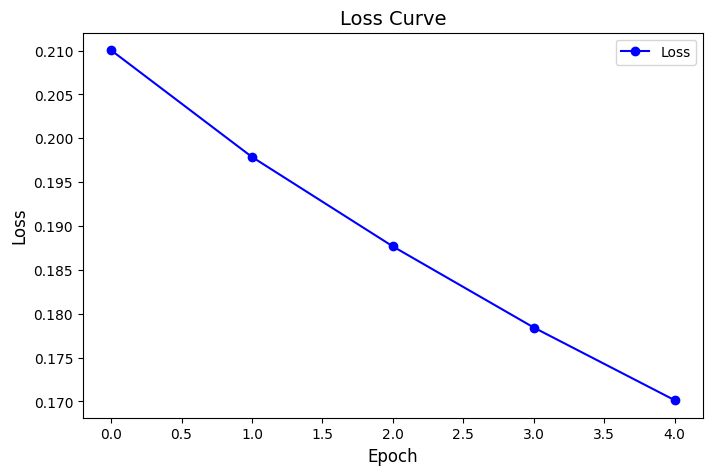

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(losses, marker='o', linestyle='-', color='b', label='Loss')
plt.title("Loss Curve", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10)
plt.show()

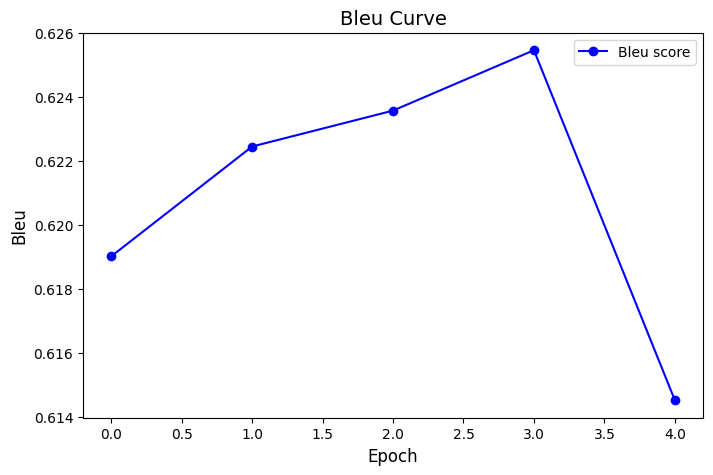

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(bleus, marker='o', linestyle='-', color='b', label='Bleu score')
plt.title("Bleu Curve", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Bleu", fontsize=12)
plt.legend(fontsize=10)
plt.show()

In [ ]:
shutil.make_archive('t5_style_transfer', 'zip', './t5_style_transfer')

files.download('t5_style_transfer.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>